In [767]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcdefaults()
import quandl
import pandas as pd
import numpy as np
import functools
import statistics
import math
import os
from datetime import datetime
import random
import scipy as sp
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
pd.options.mode.chained_assignment = None

# Assignment 3
Arjun Kilaru

# 1.1 Data Collection and Gathering

Here, we will gather the various dataframes necessary and manipulate them to create our eventual trading dataframe. In this proccess, we will set a multiindex based upon date and ticker. Data will be collected beginning on 12-31-2013 for imputation purposes. Due to download constraints, all of the data tables were downloaded as local csv files.

In [1197]:
MKTV = pd.read_csv("ZACKS_MKTV_2.csv")
MKTV = MKTV.set_index('per_end_date')
MKTV.index = pd.to_datetime(MKTV.index)
MKTV = MKTV.sort_index()
MKTV['date'] = MKTV.index
MKTV = MKTV['2013-12-31':'2022-01-31']
MKTV = MKTV.set_index(['date', 'ticker'])

In [1198]:
FR = quandl.get_table("ZACKS/FR", paginate = True)
FR = FR.set_index('per_end_date')
FR.index = pd.to_datetime(FR.index)
FR = FR.sort_index()
FR['date'] = FR.index
FR = FR['2013-12-31':'2022-01-31']
FR = FR.set_index(['date','ticker'])
FR = FR.loc[~FR.index.duplicated(keep='first')]

In [1200]:
SHRS = pd.read_csv('ZACKS_SHRS_2.csv')
SHRS = SHRS.set_index('per_end_date')
SHRS.index = pd.to_datetime(SHRS.index)
SHRS = SHRS.sort_index()
SHRS['date'] = SHRS.index
SHRS = SHRS['2013-12-31':'2022-01-31']
SHRS = SHRS.set_index(['date','ticker'])

In [1201]:
FC = pd.read_csv("ZACKS_FC_2.csv")
FC = FC.set_index('per_end_date')
FC.index = pd.to_datetime(FC.index)
FC = FC.sort_index()
FC['date'] = FC.index
FC = FC['2013-12-31':'2022-01-31']
FC = FC.set_index(['date','ticker'])
FC['zacks_sector_code'] = FC['zacks_sector_code'].fillna(100)
FC = FC.loc[~FC.index.duplicated(keep='first')]

/var/folders/96/dxthw9ns78qfsm1htv4wnqyc0000gn/T/ipykernel_1277/1542324963.py:1: DtypeWarning: Columns (4,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  FC = pd.read_csv("ZACKS_FC_2.csv")


In [1692]:
QM = pd.read_csv("QUOTEMEDIA_PRICES.csv")
QM = QM.set_index('date')
QM.index = pd.to_datetime(QM.index)
QM = QM[['ticker', 'adj_close']]
QM = QM.sort_index()
QM['date'] = QM.index
QM = QM['2013-12-31':'2022-01-31']
QM = QM.set_index(['date', 'ticker'])

# 1.2 Data Cleaning

We will now begin to write functions that check the various conditions necessary to find correct tickers. The various levels we are checking are to make sure that there are no outstanding NaN or missing values.

In [1134]:
def check_prices(ticker):
    return int(QM.xs(ticker, level = 'ticker', drop_level = False).count()) > 1782 and int(QM.xs(ticker, level = 'ticker', drop_level = False).isna().sum()) == 0

In [ ]:
#earnings = eps * shares outstanding
#divide market val by earnings (market val is numerator)
#floor is 0.01

In [1211]:
def check_debt(ticker):
    counter1 = 0
    counter2 = 0
    for index in FR.index.get_level_values(0).unique():
        if ticker in FR.loc[index].index:
            if FR.xs(ticker, level = 'ticker', drop_level = False)['tot_debt_tot_equity'].index[0][0] != pd.to_datetime('2013-12-31'):
                return False
            if math.isnan(FR.loc[index].loc[ticker, 'tot_debt_tot_equity']):
                counter1 +=1
                continue
            if FR.loc[index].loc[ticker, 'tot_debt_tot_equity'] > 0.1:
                counter2 +=1
                if counter2 > 8:
                    return True
            if counter1 > 1:
                return False
    return False

In [1204]:
def check_sector(ticker):
    for index in FC.index.get_level_values(0).unique():
        if ticker in FC.loc[index].index:
            if FC.loc[index].loc[ticker, 'zacks_sector_code'] == 5:
                return False
            if FC.loc[index].loc[ticker, 'zacks_sector_code'] == 13:
                return False
            if FC.loc[index].loc[ticker, 'zacks_sector_code'] == 100:
                return False
            return True

In [1268]:
def feasible_calculation(ticker):
    try:    
        if FR.xs(ticker, level = 'ticker', drop_level = False)['tot_debt_tot_equity'].isna().sum() > 0:
            return False
        if MKTV.xs(ticker, level = 'ticker', drop_level = False)['mkt_val'].isna().sum() > 0:
            return False
        if FC.xs(ticker, level = 'ticker', drop_level = False)['filing_date'].isna().sum()>0:
            return False
        rets = FR.xs(ticker, level = 'ticker', drop_level = False)['ret_invst']
        mkt_val = MKTV.xs(ticker, level = 'ticker', drop_level = False)['mkt_val']
        net = FC.xs(ticker, level = 'ticker', drop_level = False)['net_lterm_debt'].fillna(0)
        tot = FC.xs(ticker, level = 'ticker', drop_level = False)['tot_lterm_debt']
        return_on_investment = rets / (mkt_val + net)
        if return_on_investment.sum() == 0:
            return False
        eps = FC.xs(ticker, level = 'ticker', drop_level = False)['basic_net_eps'].clip(lower = 0.0001)
        shares = SHRS.xs(ticker, level = 'ticker', drop_level = False)['shares_out']
        earnings = eps * shares
        price_to_earnings = mkt_val / earnings
        if (price_to_earnings == 0).any():
            return False
        return True
    except:
        return False

In [1206]:
def check_ticker(ticker):
    return check_prices(ticker) and check_debt(ticker) and check_sector(ticker) and feasible_calculation(ticker)

# 1.3 Ticker Gathering
We will now get the entire list of tickers from QuoteMedia, randomize them, and iterate through them until we arrive at a list of 200. Then, we will filter the daily QuoteMedia Prices dataframe to only contain rows belonging to our tickers.

In [1269]:
tickers = QM.index.get_level_values(1).unique().tolist()
random.shuffle(tickers)

def get_tickers(tickers):
    tickerlist = []
    for i in range(len(tickers)):
        if check_ticker(tickers[i]):
            tickerlist.append(tickers[i])
        if len(tickerlist) > 200:
            return tickerlist

ticks = get_tickers(tickers)

In [1270]:
quantiles = QM[QM.index.get_level_values('ticker').isin(ticks)]

# 1.4 Database Creation
We will isolate necessary columns and eliminate rows with tickers we are not using. Then, we will merge on date and ticker to get one multi-index dataframe.

In [1271]:
FR1 = FR[['tot_debt_tot_equity', 'ret_invst']]
FC1 = FC[['net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps', 'filing_date']]
MKTV1 = MKTV[['mkt_val']]
SHRS1 = SHRS[['shares_out']]
FR1 = FR1[FR1.index.get_level_values('ticker').isin(ticks)]
FC1 = FC1[FC1.index.get_level_values('ticker').isin(ticks)]
MKTV1 = MKTV1[MKTV1.index.get_level_values('ticker').isin(ticks)]
SHRS1 = SHRS1[SHRS1.index.get_level_values('ticker').isin(ticks)]

In [1272]:
quantiles = pd.merge(quantiles, FR1, left_on = ['date', 'ticker'], right_on = ['date', 'ticker'], how = 'left') 
quantiles = pd.merge(quantiles, FC1, left_on = ['date', 'ticker'], right_on = ['date', 'ticker'], how = 'left') 
quantiles = pd.merge(quantiles, MKTV1, left_on = ['date', 'ticker'], right_on = ['date', 'ticker'], how = 'left') 
quantiles = pd.merge(quantiles, SHRS1, left_on = ['date', 'ticker'], right_on = ['date', 'ticker'], how = 'left') 

In [1273]:
quantiles['filing_date'] = pd.to_datetime(quantiles['filing_date'])

# 2.1 Daily Imputation
We will use the techniques described in the assignment page to impute daily values of all the tickers. According to the TA, only the mkt_val and debt to ratio (or tot_debt_tot_equity) columns require daily adjustmend based on closing prices. The rest of the columns are taken from the value realized at their filing date.

In [1276]:
def get_mkt_vals_and_debt(df, stat):
    if stat == "mkt_val":
        j = 1
    if stat == "tot_debt_tot_equity":
        j = 4
    df['filing_date'] = df['filing_date'].ffill()
    df['date'] = df.index
    date1 = df['filing_date'][0]
    date2 = df['filing_date'][0]
    switch = False
    switch2 = False
    for i in range(len(df)):
        if not switch and not switch2 and df.iloc[i,j]:
            switch = True
            last_known_p = df.iloc[i,0]
            last_known_m = df.iloc[i,j]            
        if df.iloc[i,3][0] == date1 and not switch and not switch2:
            df.iloc[i,j] = last_known_m * df.iloc[i,0] / last_known_p
            
        if df.iloc[i,3][0] == date2 and not switch2:
            df.iloc[i,j] = last_known_m * df.iloc[i,0] / last_known_p
        
        if df.iloc[i,3][0] > date2 and not switch2:
            df.iloc[i,j] = last_known_m * df.iloc[i,0] / last_known_p         
        
        if df.iloc[i,2] != date2 and not switch2:
            date2 = df.iloc[i,2]
            switch2 = True
            second_last_m = last_known_m
            second_last_p = last_known_p
            last_known_m = df.iloc[i,j]
            last_known_p = df.iloc[i,0]
        
        if switch2 and df.iloc[i,3][0] < date2:
            df.iloc[i,j] = second_last_m * df.iloc[i,0] / second_last_p
        
        if switch2 and df.iloc[i,3][0] >= date2 and date2 == df.iloc[i,2]:
            df.iloc[i,j] = last_known_m * df.iloc[i,0] / last_known_p 
        
        if switch2 and date2 != df.iloc[i,2]:
            date2 = df.iloc[i,2]
            second_last_m = last_known_m
            second_last_p = last_known_p
            last_known_p = df.iloc[i,0]
            last_known_m = df.iloc[i,j]
            df.iloc[i,j] = second_last_m * df.iloc[i,0] / second_last_p 
    return df

adj_close  tot_debt_tot_equity  ret_invst  net_lterm_debt  \
date       ticker                                                               
2013-12-31 MMLP     18.756056               2.5294    -4.4031         180.191   
           FONR     21.208000               0.3228     5.7961          -2.195   
           MDLZ     29.516640               0.5250     4.9602       -3589.000   
           IFF      70.695647               0.6358    14.7327         197.786   
           AXAS     65.220000               0.5055    36.3966         -80.826   
...                       ...                  ...        ...             ...   
2022-01-31 LAD     290.345698                  NaN        NaN             NaN   
           TPR      36.825619                  NaN        NaN             NaN   
           RUSHA    51.973976                  NaN        NaN             NaN   
           EBAY     58.971841                  NaN        NaN             NaN   
           YORW     44.572543                  NaN        NaN             NaN   

                   tot_lterm_debt  eps_diluted_net  basic_net_eps filing_date  \
date       ticker                                                               
2013-12-31 MMLP           658.695            -1.45          -1.44  2014-03-03   
           FONR            10.530             0.31           0.33  2014-02-18   
           MDLZ         14482.000             2.19           2.21  2014-03-03   
           IFF            932.665             4.29           4.32  2014-02-25   
           AXAS            41.790             5.80           5.80  2014-03-17   
...                           ...              ...            ...         ...   
2022-01-31 LAD                NaN              NaN            NaN         NaT   
           TPR                NaN              NaN            NaN         NaT   
           RUSHA              NaN              NaN            NaN         NaT   
           EBAY               NaN              NaN            NaN         NaT   
           YORW               NaN              NaN            NaN         NaT   

                    mkt_val  shares_out  
date       ticker                        
2013-12-31 MMLP     1139.55       26.63  
           FONR      127.46        6.01  
           MDLZ    61908.78     1753.79  
           IFF      7008.49       81.51  
           AXAS      302.83        4.64  
...                     ...         ...  
2022-01-31 LAD          NaN         NaN  
           TPR          NaN         NaN  
           RUSHA        NaN         NaN  
           EBAY         NaN         NaN  
           YORW         NaN         NaN  

[408797 rows x 10 columns]

In [1283]:
quantiles1 = quantiles
quantiles1['date'] = quantiles1.index
quantiles1 = quantiles1[['adj_close', 'mkt_val', 'filing_date', 'date', 'tot_debt_tot_equity', 'ret_invst', 'net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps', 'shares_out']]
quantiles1 = quantiles1.groupby(level='ticker').apply(get_mkt_vals_and_debt, 'mkt_val')
quantiles1 = quantiles1.groupby(level='ticker').apply(get_mkt_vals_and_debt, 'tot_debt_tot_equity')
quantiles2 = quantiles1

In [1284]:
def get_imputes(df, col):
    j = {'tot_debt_tot_equity':4,'ret_invst': 5, 'net_lterm_debt': 6, 'tot_lterm_debt': 7, 'eps_diluted_net': 8, 'basic_net_eps':9, 'shares_out': 10}
    j = j.get(col)
    date1 = df['filing_date'][0]
    df['ret_invst'] = df['ret_invst'].fillna(0)
    date2 = df['filing_date'][0]
    switch = False
    switch2 = False
    for i in range(len(df)):
        if df.iloc[i,j] == 0 and not switch and not switch2:
            continue
        if df.iloc[i,j] != 0 and not switch and not switch2:
            date2 = df.iloc[i,2]
            last_known_value = df.iloc[i,j]
            switch = True
        
        if df.iloc[i,2] != date2 and not switch2:
            date2 = df.iloc[i,2]
            switch2 = True
            second_last_value = last_known_value
            
            last_known_value = df.iloc[i,j]
        if df.iloc[i,3][0] == date2 and not switch2:
            df.iloc[i,j] = last_known_value
            
        if df.iloc[i,3][0] > date2 and not switch2:
            df.iloc[i,j] = last_known_value
            
        if switch2 and df.iloc[i,3][0] < date2:
            df.iloc[i,j] = second_last_value
        if switch2 and df.iloc[i,3][0] >= date2 and date2 == df.iloc[i,2]:
            df.iloc[i,j] = last_known_value
        if switch2 and date2 != df.iloc[i,2]:
            date2 = df.iloc[i,2]
            second_last_value = last_known_value 
            last_known_value = df.iloc[i,j]
            df.iloc[i,j] = second_last_value
            
    return df
            

In [1285]:
quantiles1 = quantiles1.groupby(level='ticker').apply(get_imputes, 'ret_invst')

In [1286]:
quantiles1 = quantiles1.groupby(level='ticker').apply(get_imputes, 'net_lterm_debt')
quantiles1 = quantiles1.groupby(level='ticker').apply(get_imputes, 'tot_lterm_debt')
quantiles1['net_lterm_debt'] = quantiles1['net_lterm_debt'].groupby(level = 'ticker').fillna(quantiles1['tot_lterm_debt'])

In [1288]:
quantiles1 = quantiles1.groupby(level='ticker').apply(get_imputes, 'eps_diluted_net')
quantiles1 = quantiles1.groupby(level='ticker').apply(get_imputes, 'basic_net_eps')
quantiles1 = quantiles1.groupby(level='ticker').apply(get_imputes, 'shares_out')

## 2.1.2 Funding and Repo Rates

I decided to use the Risk-Free Rate (taken from FRED database) as the rate I pay on keeping my short positions. I saw that on Ed, Prof. Boonstra suggested using this rate as it does not go negative. Given that this rate is likely higher than what the funding rate and repo rate would be, I also absolve the funding rate into this rate.

When my strategy is implemented, I will calculate the daily values that I owe as a result of the short positions and sum these across the month. When my PnLs for the month are realized, I will subtract the sum of the daily losses that have accumulated as a result of having to pay the repo rate. 

In [1966]:
fama = pd.read_csv("DGS10.csv")
fama.index = pd.to_datetime(fama['DATE'])
fama = fama[['DGS10']]

rfs = fama['DGS10'].tolist()
for i, val in enumerate(rfs):
    try:
        rfs[i] = float(val)
    except ValueError:
        rfs[i] = np.nan
fama['DGS10'] = rfs
fama['DGS10'] = fama['DGS10'].ffill()
fama['DGS10'] = fama['DGS10'] * 0.01 / 365
fama = fama.loc[:'2022-01-31']
quantiles1['RF'] = fama['DGS10']
#fama.head()
for date, group in quantiles1.groupby(level='date'):
    group['RF'] = fama['DGS10'].loc[date]
    quantiles1.loc[date] = group

quantiles1.head()

adj_close        mkt_val filing_date  \
date       ticker                                          
2015-01-02 AWI      42.187302    2775.139086  2015-02-23   
           NPTN      3.300000     107.422388  2015-03-16   
           GE      167.703547  253959.894023  2015-02-27   
           WLFC     21.620000     181.199201  2015-03-16   
           TAST      6.899775     267.699578  2015-03-04   

                                          date  tot_debt_tot_equity  \
date       ticker                                                     
2015-01-02 AWI      (2015-01-02 00:00:00, AWI)             1.220392   
           NPTN    (2015-01-02 00:00:00, NPTN)             0.286755   
           GE        (2015-01-02 00:00:00, GE)             1.947135   
           WLFC    (2015-01-02 00:00:00, WLFC)             3.688675   
           TAST    (2015-01-02 00:00:00, TAST)             1.325030   

                   ret_invst  net_lterm_debt  tot_lterm_debt  eps_diluted_net  \
date       ticker                                                               
2015-01-02 AWI        2.6082         -16.300        1013.600           0.5700   
           NPTN      -1.1094          -0.546          15.448           0.0001   
           GE         0.7858       -8049.000      213179.000           2.8000   
           WLFC       0.4502           4.553           0.000           0.1200   
           TAST      -0.5741          -0.756         165.448           0.0001   

                   basic_net_eps  shares_out        RF  debt_to_mkt_cap  \
date       ticker                                                         
2015-01-02 AWI            0.5700       54.89  0.000058         1.220392   
           NPTN           0.0001       32.55  0.000058         0.286755   
           GE             2.8000     1255.28  0.000058         1.947135   
           WLFC           0.1200        8.38  0.000058         3.688675   
           TAST           0.0001       35.22  0.000058         1.325030   

                   ret_on_invst  earnings_per_share  
date       ticker                                    
2015-01-02 AWI         0.000945           88.698580  
           NPTN       -0.010380        33002.269757  
           GE          0.000003           72.254766  
           WLFC        0.002424          180.190136  
           TAST       -0.002151        76007.830227

In [1967]:
quantiles1

adj_close        mkt_val filing_date  \
date       ticker                                          
2015-01-02 AWI      42.187302    2775.139086  2015-02-23   
           NPTN      3.300000     107.422388  2015-03-16   
           GE      167.703547  253959.894023  2015-02-27   
           WLFC     21.620000     181.199201  2015-03-16   
           TAST      6.899775     267.699578  2015-03-04   
...                       ...            ...         ...   
2022-01-31 LAD     290.345698    8855.287612  2022-02-18   
           TPR      36.825619   10505.409056  2022-02-10   
           RUSHA    51.973976    2942.365300  2022-02-24   
           EBAY     58.971841   39153.046008  2022-02-24   
           YORW     44.572543     597.041731  2022-03-08   

                                           date  tot_debt_tot_equity  \
date       ticker                                                      
2015-01-02 AWI       (2015-01-02 00:00:00, AWI)             1.220392   
           NPTN     (2015-01-02 00:00:00, NPTN)             0.286755   
           GE         (2015-01-02 00:00:00, GE)             1.947135   
           WLFC     (2015-01-02 00:00:00, WLFC)             3.688675   
           TAST     (2015-01-02 00:00:00, TAST)             1.325030   
...                                         ...                  ...   
2022-01-31 LAD       (2022-01-31 00:00:00, LAD)             0.773560   
           TPR       (2022-01-31 00:00:00, TPR)             0.521053   
           RUSHA   (2022-01-31 00:00:00, RUSHA)             0.701041   
           EBAY     (2022-01-31 00:00:00, EBAY)             0.717369   
           YORW     (2022-01-31 00:00:00, YORW)             0.916044   

                   ret_invst  net_lterm_debt  tot_lterm_debt  eps_diluted_net  \
date       ticker                                                               
2015-01-02 AWI        2.6082        -16.3000        1013.600           0.5700   
           NPTN      -1.1094         -0.5460          15.448           0.0001   
           GE         0.7858      -8049.0000      213179.000           2.8000   
           WLFC       0.4502          4.5530           0.000           0.1200   
           TAST      -0.5741         -0.7560         165.448           0.0001   
...                      ...             ...             ...              ...   
2022-01-31 LAD        4.3334       -520.7999        2586.100          10.1100   
           TPR        5.2264         -0.2000        1191.400           0.8000   
           RUSHA      3.8328       -166.4060         397.884           1.2000   
           EBAY       1.5156       1322.0000        7727.000           0.4000   
           YORW       1.6948          8.4920         132.197           0.3600   

                   basic_net_eps  shares_out        RF  debt_to_mkt_cap  \
date       ticker                                                         
2015-01-02 AWI            0.5700       54.89  0.000058         1.220392   
           NPTN           0.0001       32.55  0.000058         0.286755   
           GE             2.8000     1255.28  0.000058         1.947135   
           WLFC           0.1200        8.38  0.000058         3.688675   
           TAST           0.0001       35.22  0.000058         1.325030   
...                          ...         ...       ...              ...   
2022-01-31 LAD           10.1100       30.28  0.000049         0.773560   
           TPR            0.8200      275.14  0.000049         0.521053   
           RUSHA          1.2400       55.51  0.000049         0.701041   
           EBAY           0.4100      650.06  0.000049         0.717369   
           YORW           0.3600       13.09  0.000049         0.916044   

                   ret_on_invst  earnings_per_share  
date       ticker                                    
2015-01-02 AWI         0.000945           88.698580  
           NPTN       -0.010380        33002.269757  
           GE          0.000003           72.254766  
  

# 2.2 Ratio Creation
We will use the imputed values to create columns containing the different fundamental ratios described. We will create our trading dataframe that contains these ratios and the daily adjusted closing prices.

In [1811]:
quantiles1 = quantiles1.loc['2015-01-01':]
quantiles1['mkt_val'] = quantiles1['mkt_val'].groupby(level='ticker').ffill()
quantiles1['debt_to_mkt_cap'] = quantiles1['tot_debt_tot_equity'].groupby(level='ticker').ffill()
quantiles1['ret_on_invst'] = quantiles1['ret_invst'] / (quantiles1['net_lterm_debt'] + quantiles1['mkt_val'])
quantiles1['basic_net_eps'] = quantiles1['basic_net_eps'].clip(lower = 0.0001).fillna(0)
quantiles1['eps_diluted_net'] = quantiles1['eps_diluted_net'].clip(lower = 0.0001).fillna(0)
quantiles1['tot_lterm_debt'] = quantiles1['tot_lterm_debt'].fillna(0)
quantiles1['net_lterm_debt'] = quantiles1['net_lterm_debt'].fillna(0)
quantiles1['earnings_per_share'] = quantiles1['mkt_val'] / (quantiles1['eps_diluted_net'] * quantiles1['shares_out'])
quantiles1['ret_on_invst'] = quantiles1['ret_on_invst'].fillna(0)

In [1893]:
trading_data = quantiles1[['adj_close','debt_to_mkt_cap', 'ret_on_invst', 'earnings_per_share', 'RF']]

# 3.1 Quantile Trading
We will write functions to implement a quantile trading strategy. The overall function, trading_strategy, takes in the dataframe and a ratio to trade upon. The get_position helper function sets the weights to each index in the specified quantile. To begin, it is set to weigh the top 2.5% with a weight of 0.1, the next 2.5% with a weight of 0.05, and the next 5% with a weight of 0.025. The weights sum to one. In the future, we will analyze the strategy with different position sizings. It is important to note that we are sorting descending only for debt to market cap and earnings per share. That means we buy the company with low values and short the companies with high values. For all other ratios, it is the inverse. 

In [1894]:
def get_position(df, length):
    if df['count'] <= 5:
        return -0.1
    if df['count'] <= 10:
        return -0.05
    if df['count'] <= 20:
        return -0.025
    if df['count'] >= length-4:
        return 0.1
    if df['count'] >= length-9 and df['count'] < length-4:
        return 0.05
    if df['count'] >= length-19 and df['count'] < length-4:
        return 0.025
    else: return 0
    

def match_positions(df1, df2):
    for i in range(len(df1)):
        tickername = df1.iat[i,0]
        try:
            second_index = int(df2[df2['ticker'] == tickername].index.tolist()[0]-1)
            df2.iat[second_index,7] = df1.iat[i,7]
            df2.iat[second_index,8] = df1.iat[i,8] 
        except:
            continue
    df2['position'] = df2['position_units'] * df2['adj_close']
    return df2

#first five stocks have weight 0.1, next 5 have weight 0.05, next 10 have weight 0.025


In [1907]:
def trading_strategy(trading_data, ratio):
    trading_data = trading_data[['adj_close', ratio, 'RF']]
    if ratio == 'debt_to_mkt_cap' or ratio == 'earnings_per_share':
        trading_data = trading_data.sort_values(by=['date', ratio], ascending=[True, False])
    else:
        trading_data = trading_data.sort_values(by=['date', ratio], ascending=[True, True])
    trading_data['PnL'] = 0
    trading_data['cum_pnl'] = 0
    trading_data['position_weight'] = 0
    trading_data['position_units'] = 0
    trading_data['position'] = 0
    trading_data['repo'] = 0
    cum_pnl = 0
    daily_losses = 0 #NOTE HOW THIS IS ADDED PLS
    pnl_graph = []
    notional = 1000
    initial_capital = 10*notional
    switch = False
    for date, group in trading_data.groupby(level='date'):
        if group[ratio].sum() == 0:
            continue
        if not switch:
            month = group.index.get_level_values(level = 'date')[0].month
            trim = group.copy()
            trim = trim.droplevel(0)
            trim['ticker'] = trim.index
            trim.index = range(1, len(trim) + 1)
            trim['count'] = trim.index
            trim = trim[['ticker', 'count','adj_close', ratio, 'PnL', 'cum_pnl', 'RF']]
            length = len(trim)
            trim['position_weight'] = trim.apply(get_position, length = length, axis = 1)
            trim['position_units'] = trim['position_weight'] * notional / trim['adj_close']
            trim['position'] = trim['position_units'] * trim['adj_close']
            group['position_weight'] = trim['position_weight'].tolist()
            group['position_units'] = trim['position_units'].tolist()
            group['position'] = trim['position'].tolist()
            trading_data.loc[date] = group
            switch = True
            continue
        if switch and group.index.get_level_values(level = 'date')[0].month == month:
            trim2 = group.copy()
            RF = group['RF']
            trim2 = trim2.droplevel(0)
            trim2['ticker'] = trim2.index
            trim2.index = range(1, len(trim2) + 1)
            trim2['count'] = trim2.index
            trim2 = trim2[['ticker', 'count','adj_close', ratio, 'PnL', 'cum_pnl', 'RF']]
            trim2['position_weight'] = 0
            trim2['position_units'] = 0
            trim2['position'] = 0
            trim2 = match_positions(trim, trim2)
            group['position_weight'] = trim2['position_weight'].tolist()
            group['position_units'] = trim2['position_units'].tolist()
            group['position'] = trim2['position'].tolist()
            group['cum_pnl'] = cum_pnl
            group['RF'] = RF
            group['repo'] = np.where(group['position'] < 0, group['position'] * group['RF'], 0)
            daily_losses = daily_losses + group['repo'].sum()
            pnl_graph.append(cum_pnl/initial_capital)
            trading_data.loc[date] = group
        if switch and group.index.get_level_values(level = 'date')[0].month != month:
            trim2 = group.copy()
            trim2 = trim2.droplevel(0)
            trim2['ticker'] = trim2.index
            trim2.index = range(1, len(trim2) + 1)
            trim2['count'] = trim2.index
            trim2 = trim2[['ticker', 'count','adj_close', ratio, 'PnL', 'cum_pnl', 'RF']]
            trim2['position_weight'] = 0
            trim2['position_units'] = 0
            trim2['position'] = 0
            trim2 = match_positions(trim, trim2)
            group['position_weight'] = trim2['position_weight'].tolist()
            group['position_units'] = trim2['position_units'].tolist()
            group['position'] = trim2['position'].tolist() 
            cum_pnl = cum_pnl + group['position'].sum() + daily_losses
            daily_losses = 0
            pnl_graph.append(cum_pnl/initial_capital)
            group['cum_pnl'] = cum_pnl
            group['position_weight'] = 0
            group['position_units'] = 0
            group['position'] = 0            
            month = group.index.get_level_values(level = 'date')[0].month
            trim = group.copy()
            trim = trim.droplevel(0)
            trim['ticker'] = trim.index
            trim.index = range(1, len(trim) + 1)
            trim['count'] = trim.index
            trim = trim[['ticker', 'count','adj_close', ratio, 'PnL', 'cum_pnl', 'RF']]
            length = len(trim)
            trim['position_weight'] = trim.apply(get_position, length = length, axis=1)
            trim['position_units'] = trim['position_weight'] * notional / trim['adj_close']
            trim['position'] = trim['position_units'] * trim['adj_close']
            group['position_weight'] = trim['position_weight'].tolist()
            group['position_units'] = trim['position_units'].tolist()
            group['position'] = trim['position'].tolist()
            trading_data.loc[date] = group
    pnls = [x for i, x in enumerate(pnl_graph) if x not in pnl_graph[:i]]
    return (trading_data, pnls)

## 3.2 Performance Analysis: New Variable
We will now analyze the performance of our trading strategy. First, in accordance with the assignment, we will create a new ratio to analyze. I chose to analyze the sum of the squared standardized return on investment and the squared standardized debt to market cap ratios. I chose the square because that may provide an increasingly interesting analysis given that return on investment and debt to market cap are sorted in opposite orders, so squaring the terms helps preserve their differences from the mean. Overall, Prof. Boonstra said that we could be relatively arbitrary in this selection, so I chose the sum of two squared standardized ratios. 

In [1915]:
from scipy.stats import zscore
debt_zs = (trading_data['debt_to_mkt_cap'] - trading_data['debt_to_mkt_cap'].mean())/trading_data['debt_to_mkt_cap'].std()
ret_zs = (trading_data['ret_on_invst'] - trading_data['ret_on_invst'].mean())/trading_data['ret_on_invst'].std()
trading_data['non_trivial_combo'] = (debt_zs * debt_zs) + (ret_zs * ret_zs)

## 3.3 Performance Analysis: Graphing PnLs
In order to assess the performance, we will graph the PnLs of each strategy. 

In [ ]:
import matplotlib
matplotlib.style.use('seaborn')

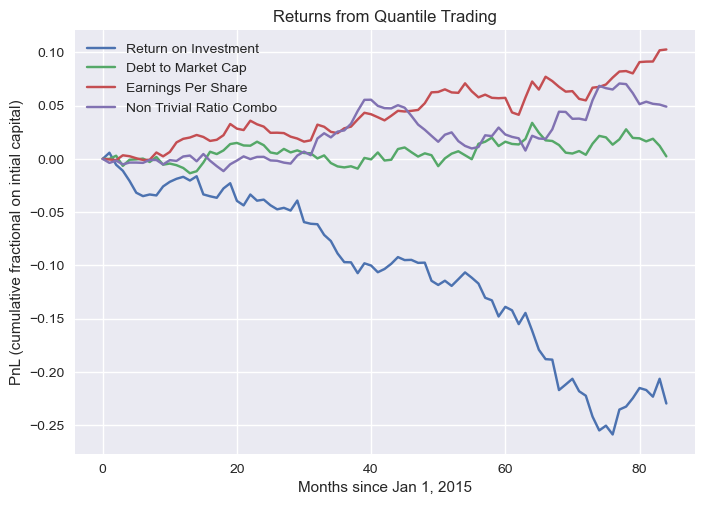

In [1908]:
rets = trading_strategy(trading_data, 'ret_on_invst')
rets2 = trading_strategy(trading_data, 'debt_to_mkt_cap')
rets3 = trading_strategy(trading_data, 'earnings_per_share')
rets4 = trading_strategy(trading_data, 'non_trivial_combo')

matplotlib.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(rets[1], label='Return on Investment')
ax.plot(rets2[1], label='Debt to Market Cap')
ax.plot(rets3[1], label='Earnings Per Share')
ax.plot(rets4[1], label='Non Trivial Ratio Combo')
ax.legend()
plt.xlabel("Months since Jan 1, 2015")
plt.ylabel('PnL (cumulative fractional on intial capital)')
plt.title('Returns from Quantile Trading')
plt.show()

In [1936]:
from statistics import mean, stdev
print(mean(rets[1]))
print(stdev(rets[1]))
print(mean(rets2[1]))
print(stdev(rets2[1]))
print(mean(rets3[1]))
print(stdev(rets3[1]))
print(mean(rets4[1]))
print(stdev(rets4[1]))

-0.10649154788071338
0.07567175410299759
0.006615924553240361
0.009543569260086556
0.042630429610230794
0.026840131072238343
0.022165279828085614
0.0231250019341208


In [1951]:
import scipy
scipy.stats.ttest_1samp(rets2[1], 0)
scipy.stats.shapiro(rets4[1])

ShapiroResult(statistic=0.9184924364089966, pvalue=4.907551556243561e-05)

### 3.3.1 Analysis of Returns

The units for the y-axis are fractional returns, meaning the the fraction of cumulative PnL / initial capital, which i set to $10,000. As such, a PnL of 1 would indicate a return of 100 percent on the initial capital. My overall monthly notional (the amount I invested each month) was 1000 dollars in both short and long positions, so the gross notional was 2000 dollars. I made the x-axis months since the position opening, which I prefer to it just being the explicit date, as this x axis gives the reader an understanding of how long the positions have been kept open. I hope that reasoning is OK for keeping the x axis like that. 

The strategy based on return on investment ratio had a mean return of -0.106 with a st.dev. of 0.075. The strategy based on debt to market cap had a mean return of 0.0066 and a standard deviation of 0.0095. The strategy based on price to earnings had a mean return of 0.0426 and a standard deviation of 0.0268. The strategy based on the newly created ratio had a mean of 0.022 and a standard deviation of 0.023. 

The returns for the return on investment ratio strategy were negatively correlated with the other returns. All of the other returns, as can be told by the eye test, were positively correlated with one another. 

Overall, each strategy except for the return to investment ratio strategy ended slightly in the green. The strongest return came from the price to earnings ratio, which ended with a return of 10 percent. Depending on the starting capital (as we used 10*notional), this strategy may yield greater returns.

The strategy around return to investment ended significantly in the red. There were many reasons why this may have happened. The first economic reason may be the general recession that affected the economy after and during COVID-19. It is observed that around the 60 month mark, which is Jan 1, 2020, the returns significantly decreased, as most equity prices fell as a result of the pandemic. The return to investment metric may have been especially affected by this, and as a result the strategy may have had a more difficult time discerning a ranking that yields positive results. 

One reason for the lack of significantly positive returns may be the lack of sophistication regarding the weights, and the lack of up-to-date knowledge on the various ratios. The weights I chose could have been better constructed to reflect a more complex strategy, as opposed to a simple of 50-75-100 allocation based on the percentiles. Furthermore, the ratios could have been calculated with a higher degree of precision, using methods to impute the daily values of debt and earnings as opposed to simply using the filing date readings.

I applied one sample t-tests to the returns to see if they can be classified as zero-mean noise. All of the returns rejected the null hypothesis of zero mean at any reasonable alpha level.

Regarding Schapiro-Wilk tests for normality, all returns except for the debt to market cap ratio rejected the null hypothesis of normal data. However, since the mean is not zero according to the t-test, this is not a cause for concern or further analysis.  


## 3.4 Performance Analysis: Using Changes in Ratio

We will now set our ratios as their percent change as opposed to their gross values.

In [1909]:
trading_data_1 = trading_data.copy()
trading_data_1['ret_on_invst'] = trading_data_1['ret_on_invst'].groupby(level='ticker').pct_change().ffill()
trading_data_1['earnings_per_share'] = trading_data_1['earnings_per_share'].groupby(level='ticker').pct_change().ffill()
trading_data_1['debt_to_mkt_cap'] = trading_data_1['debt_to_mkt_cap'].groupby(level='ticker').pct_change().ffill()
trading_data_1['non_trivial_combo'] = trading_data_1['non_trivial_combo'].groupby(level='ticker').pct_change().ffill()

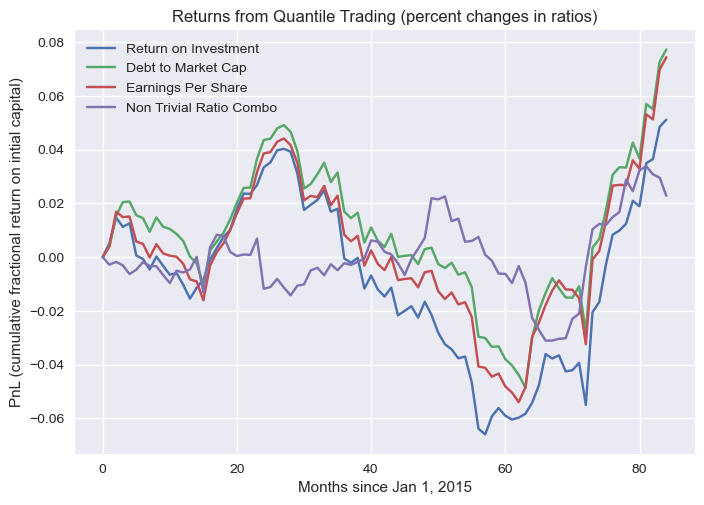

In [1910]:
rets11 = trading_strategy(trading_data_1, 'ret_on_invst')
rets21 = trading_strategy(trading_data_1, 'debt_to_mkt_cap')
rets31 = trading_strategy(trading_data_1, 'earnings_per_share')
rets41 = trading_strategy(trading_data_1, 'non_trivial_combo')

matplotlib.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(rets11[1], label='Return on Investment')
ax.plot(rets21[1], label='Debt to Market Cap')
ax.plot(rets31[1], label='Earnings Per Share')
ax.plot(rets41[1], label='Non Trivial Ratio Combo')
ax.legend()
plt.xlabel("Months since Jan 1, 2015")
plt.ylabel('PnL (cumulative fractional return on intial capital)')
plt.title('Returns from Quantile Trading (percent changes in ratios)')
plt.show()

In [1957]:
print(mean(rets11[1]))
print(stdev(rets11[1]))
print(mean(rets21[1]))
print(stdev(rets21[1]))
print(mean(rets31[1]))
print(stdev(rets31[1]))
print(mean(rets41[1]))
print(stdev(rets41[1]))
np.corrcoef(rets21[1],rets31[1])
scipy.stats.ttest_1samp(rets31[1], 0)

-0.00753583505322649
0.030100800410944626
0.00943736352410334
0.025736793431796228
0.0030742404552189075
0.02657749639839872
-7.101795433049087e-05
0.014213722025438143


Ttest_1sampResult(statistic=1.0664321471230336, pvalue=0.289283896692587)

### 3.4.1 Analysis of Returns

All of the strategies performed positively here, with each ending in the green. The returns on investment ratio strategy had a mean return of -0.007 with a volatility (st.dev.) of 0.030. The debt to market cap ratio had a mean return of 0.009 with a volatility of 0.0257. The earnings per share ratio had a mean return of 0.003 with a volatility of 0.0265. The new ratio strategy had a mean of roughly 0 and a volatility of 0.0142. 

Interestingly, some of the strategies seemed to be relatively negatively correlated with one another. The correlation between the returns on investment and the debt to market cap strategy returns was -0.75. That relationship can also be roughly observed in the graph as well. Returns on investment and earnings per share had a correlation of -0.76.

All of the returns were positively correlated with one another. 

These strategies may have performed better as using the percent changes provides a much more constant set of securities to analyze and trade, as well as provide a better indication of performance. Relative performance in the various ratios may be a stronger indication of overall company close prices. If a company's debt to market cap drops significantly, then it may be the case that their immediate stock price will fall. If this drop, in gross (not relative) terms does not meet the percentile threshold, then we would never have traded the stock. Intuitievely, it makes sense that the percent change strategy performs better. 

All of the returns were positively correlated with each other. According to one-sample t-tests, all of the returns except for the returns using price per share and the non trivial combination rejected the null hypothesis of zero mean. 

## Performance Analysis: Changes in Weights
We will now change the weights we assign to the different elements in the quantiles and track the performance of our strategy. 

### Performance Analysis: 1/N weights
We will analyze the returns of our best-performing strategies by using 1/N weights.

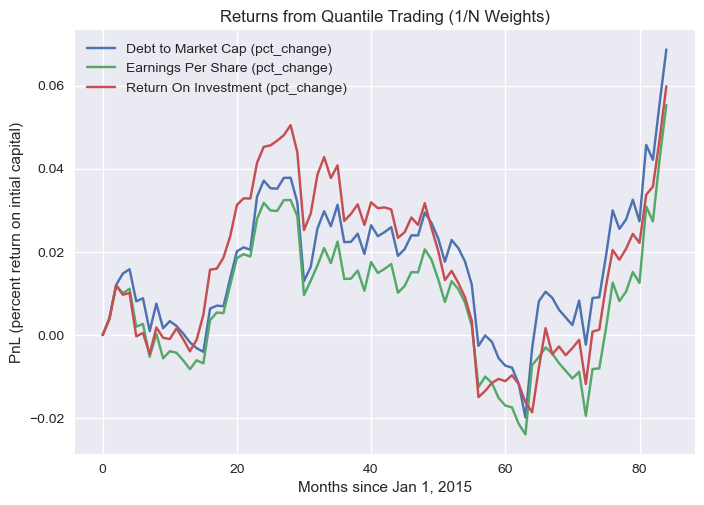

In [1934]:
def get_position(df, length):
    if df['count'] <= 20:
        return -0.05
    if df['count'] >= length-19:
        return 0.05
    else: return 0
rets333 = trading_strategy(trading_data_1, 'ret_on_invst')
rets111 = trading_strategy(trading_data_1, 'debt_to_mkt_cap')
rets222 = trading_strategy(trading_data_1, 'earnings_per_share')
matplotlib.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(rets111[1], label = 'Debt to Market Cap (pct_change)')
ax.plot(rets222[1], label = 'Earnings Per Share (pct_change)')
ax.plot(rets333[1], label = 'Return On Investment (pct_change)')

ax.legend()
plt.xlabel("Months since Jan 1, 2015")
plt.ylabel('PnL (percent return on intial capital)')
plt.title('Returns from Quantile Trading (1/N Weights)')
plt.show()

As expected, the strategies using 1/N weights performed a little worse than their previous counterparts. As you can recall, previously our weights were 50% portfolio allocation to the top and bottom 5th percentile, with the 25% allocation to the next 5th percentile and 25% to the next tenth percentile. This strategy allocates 100% across the 20th percentiles equally. The returns here are lower, indicating that the lack of weighting sophistication negatively affects returns. Logically, it would make sense to weight the extreme stocks more in order to better capture their predicted movements. 

### Performance Analysis: 85% weights in the 95th and 5th percentile. 15% weight in the remaining 80th and 20th percentile.
We will analyze the returns of our best-performing strategy( Return on Investment, no percent change) by using aforementioned weights.

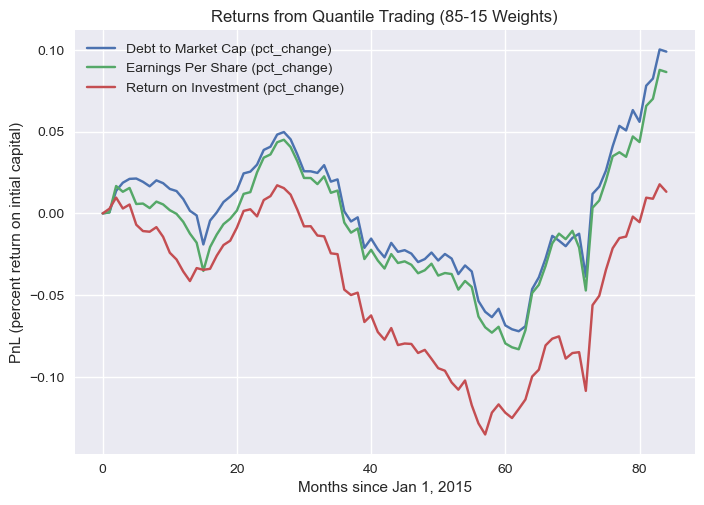

In [1935]:
def get_position(df, length):
    if df['count'] <= 5:
        return -0.15
    if df['count'] <= 20:
        return -0.01
    if df['count'] >= length - 4:
        return 0.15
    if df['count'] >= length - 19:
        return 0.01
    else: return 0

rets111 = trading_strategy(trading_data_1, 'debt_to_mkt_cap')
rets222 = trading_strategy(trading_data_1, 'earnings_per_share')
rets333 = trading_strategy(trading_data_1, 'ret_on_invst')
matplotlib.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(rets111[1], label = 'Debt to Market Cap (pct_change)')
ax.plot(rets222[1], label = 'Earnings Per Share (pct_change)')
ax.plot(rets333[1], label = 'Return on Investment (pct_change)')

ax.legend()
plt.xlabel("Months since Jan 1, 2015")
plt.ylabel('PnL (percent return on intial capital)')
plt.title('Returns from Quantile Trading (85-15 Weights)')
plt.show()

This strategy ended with a higher return than the original weights and the 1/N weights. This is also somewhat as expected, as the highest percentile of stocks are where the most price flucation can be captured. 

### Performance Analysis: 100% weights in only the top 95th and 5th percentile. 

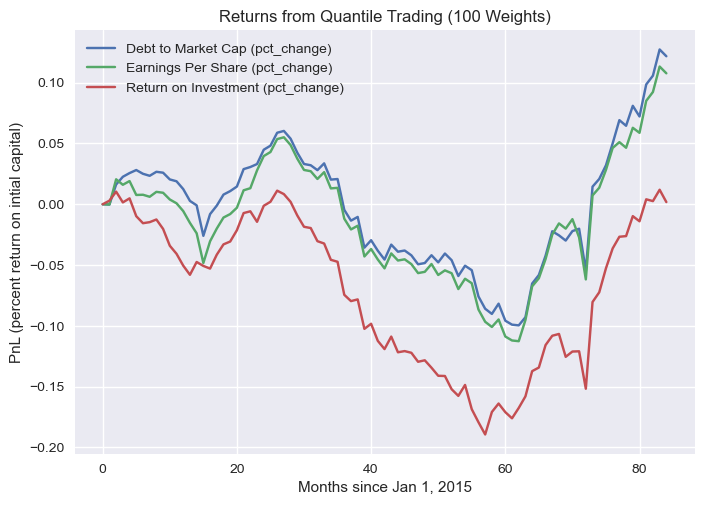

In [1958]:
def get_position(df, length):
    if df['count'] <= 5:
        return -0.2
    if df['count'] >= length-4:
        return 0.2
    else: return 0

rets111 = trading_strategy(trading_data_1, 'debt_to_mkt_cap')
rets222 = trading_strategy(trading_data_1, 'earnings_per_share')
rets333 = trading_strategy(trading_data_1, 'ret_on_invst')

matplotlib.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(rets111[1], label = 'Debt to Market Cap (pct_change)')
ax.plot(rets222[1], label = 'Earnings Per Share (pct_change)')
ax.plot(rets333[1], label = 'Return on Investment (pct_change)')

ax.legend()
plt.xlabel("Months since Jan 1, 2015")
plt.ylabel('PnL (percent return on intial capital)')
plt.title('Returns from Quantile Trading (100 Weights)')
plt.show()

In [1964]:
mean(rets333[1])

-0.07009947771949204

For Debt to Market Cap and Earnings Per Share, this strategy ended with a higher return than the original weights, the 1/N weights, and the 85-15 split. This is a slight surprise, as it was conveyed that the top and bottom 5th percentile captured enough price fluctuation to improve the ending returns. However, the overall average return is negative, indicating that a weight strategy of this nature is not benefitial in the aggregate. It may be more wise from a risk perspective to diversify the holdings among many shares as opposed to concentrating them amongst two groups of 5. The mean for the debt to market cap strategy was -0.001, the earnings per share strategy was -0.011, and the return on investment strategy was -0.07. In all instances, these were lower than the counterparts above. 

# Conclusion
Overall, it has been understood how the weights play a significant importance in the performance of the strategy. Furthermore, the style of ranking (gross values vs percent changes) also has a strong effect on the strategy performance. Depending on the starting capital, quantile trading of this nature can result in positive, adequate final returns (albiet relatively timid average returns). Economically, it is important to compare the returns of the strategy with the some benchmark. For example, comparing the returns of our best-performing strategies to the 7-year performance of SPY does not yield significantly better outcomes. Over the 7 year period, SPY mean and final returns have outperformed all of our strategie's returns (assuming the initial capital we set). Going forward, it is important to critically analyze our strategies in relation to benchmarks as well as in relation to the various parameters that we can control. 

I hope my submission has been a sucessful analysis of my decible trading strategy, where I ranked based on changes in addition to the ratios and altered the different weight sizes. Thank you. 